# Autonomous Discovery: Compound Interest Law

## What This Demonstrates

This notebook showcases **AI-driven discovery process** - where an AI agent is trying to discover a mathematical laws from data **without being told what to look for**.

### The Challenge: Compound Interest

**Compound interest** is the phenomenon where invested money grows exponentially over time as interest earns interest on itself.

**Key Concepts:**
- **Time (t)**: Investment duration in years
- **Amount (A)**: Total value after time t (in dollars)
- **The Mystery**: What is the mathematical relationship between t and A?

### Historical Context

**The true law:** A = P √ó e^(rt), where:
- P = principal (initial investment)
- r = annual interest rate (as decimal)
- t = time in years
- e ‚âà 2.71828 (Euler's number)

### Why it this interesting?

1. **No Prior Knowledge**: The AI isn't told it's compound interest or given any financial formulas
2. **Noisy Data**: Real-world measurements always have errors and uncertainty
3. **Iterative Reasoning**: The AI proposes hypotheses, evaluates them, and improves
4. **Autonomous Discovery**: The system runs end-to-end without human intervention

**Can AI rediscover the exponential growth law that governs investments, populations, and natural processes?** Let's find out!

---

**Supports:**
- Anthropic Claude API
- OpenAI API  
- Local Ollama models

## 1. Configuration
Set your API keys and preferences here:

In [ ]:
# ============================================================================
# CONFIGURATION - Edit this section
# ============================================================================

CONFIG = {
    # Choose your LLM provider: "claude", "openai", or "ollama"
    "provider": "openai",
    
    # API Keys (leave empty if using Ollama)
    "anthropic_api_key": "YOUR_ANTHROPIC_API_KEY_HERE",
    "openai_api_key": "YOUR_OPEN_AI_API_KEY_HERE",
    
    # Model names
    "claude_model": "claude-sonnet-4-20250514",
    "openai_model": "gpt-5",
    "ollama_model": "llama3.1",  # or "mistral", "codellama", etc.
    
    # Ollama settings (if using local LLM)
    "ollama_base_url": "http://localhost:11434",
    
    # Discovery settings
    "max_iterations": 3,
    "noise_level": 0.15,  # Measurement noise as fraction of true value
    #  - 0.05 (5%): Very clean data - easy for AI
    #- 0.10 (10%): Slight noise - good for presentations
    #- 0.15 (15%): Moderate noise - realistic (current setting)
    #- 0.20 (20%): High noise - challenging for AI
    #- 0.30 (30%): Very noisy - may struggle to discover law
    
    # Compound interest parameters
    "principal": 1000.0,  # Initial investment ($)
    "rate": 0.08,  # 8% annual interest rate
    
    # Optional: Enable hints if LLM struggles (set to True for easier discovery)
    "enable_hints": False,  # If True, mentions exponential growth
}

print("Configuration loaded!")
print(f"Provider: {CONFIG['provider']}")
print(f"Max iterations: {CONFIG['max_iterations']}")

Configuration loaded!
Provider: openai
Max iterations: 3


## 2. Import Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple
import requests
from discovery_methods import generate_compound_interest_data, plot_introduction, plot_noisy_data, plot_iteration, evaluate_equation, calculate_r_squared, call_claude, call_openai, call_ollama, call_llm, display_summary, parse_llm_response, build_prompt, run_autonomous_discovery

# Set up matplotlib for inline plotting
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 10

ImportError: cannot import name '_c_internal_utils' from partially initialized module 'matplotlib' (most likely due to a circular import) (C:\Python312\Lib\site-packages\matplotlib\__init__.py)

## 4. Prompt Building and Parsing

You are a scientific AI agent discovering mathematical laws from experimental data.

### EXPERIMENTAL DATA
{data_str}
<!-- Each line like: t=0.0, A=0.00 -->

**IMPORTANT:** Discover the relationship purely from the data patterns.  
Think step-by-step: examine how A changes as t changes, look for linear, polynomial, exponential, or other relationships.

### PREVIOUS ATTEMPTS (if any)
Iteration {prev_iteration}: {equation} (R¬≤={r_squared})
<!-- Repeat for each previous attempt, if present -->

### Your task for iteration {iteration}
1. Analyze the relationship between t and A in the data
2. Propose a mathematical equation: A = [function of t]
3. Explain your reasoning ‚Äî what patterns do you see?
4. Use mathematical notation

**Respond in this EXACT format:**
REASONING: [Your step-by-step analysis]  
EQUATION: [Just the expression]  
CONFIDENCE: [Low/Medium/High]

## 5. Main Discovery Loop

### Autonomous Scientific Discovery ‚Äî Loop Overview

This document explains the control flow of the autonomous discovery loop (previously implemented as `run_autonomous_discovery`). It‚Äôs written to be presentation-friendly for a non-code audience.

---

#### Purpose
Iteratively propose and evaluate mathematical laws that relate **time (t)** to a measured **amount (A)** using an LLM, until a high-quality fit is found or a maximum number of iterations is reached.

---

#### Inputs
- **t**: array of time values (independent variable)
- **A_noisy**: array of measured amounts with noise (dependent variable)
- **config**:
  - `provider`: which LLM backend to use (e.g., `claude`, `openai`, `ollama`)
  - `claude_model` / `openai_model` / `ollama_model`: model identifier (depending on provider)
  - `max_iterations`: maximum number of loop iterations (e.g., 10)

---

#### External Capabilities Used
- **build_prompt(t, A, iteration, previous_iterations, config)** ‚Üí Formats the data and context into an LLM prompt.
- **call_llm(prompt, config)** ‚Üí Sends the prompt to the selected LLM and returns raw text.
- **parse_llm_response(text)** ‚Üí Extracts:
  - `reasoning` (narrative analysis),
  - `equation` (proposed formula, e.g., `A = ...`),
  - `confidence` (Low/Medium/High).
- **evaluate_equation(equation, t)** ‚Üí Computes model predictions **AÃÇ(t)** from the equation.
- **calculate_r_squared(A_true, A_pred)** ‚Üí Returns **R¬≤** to quantify goodness of fit.
- **plot_iteration(t, A_noisy, AÃÇ, equation, r¬≤, iteration)** ‚Üí Visualizes data vs. prediction.

---

#### Outputs
- **iterations**: a list of per-iteration records containing:
  - `iteration`, `prompt`, `response`, `reasoning`, `equation`, `confidence`,
  - `r_squared`, `predictions` (AÃÇ over t).

---

#### Success Criterion
- Discovery ends early if **R¬≤ > 0.99** (excellent fit).
- Otherwise, runs until `max_iterations` is reached.

---

#### High-Level Flow (Bullet Summary)
1. **Initialization & Logging**
   - Announce provider, model, and `max_iterations`.
2. **For each iteration `i = 1..max_iterations`:**
   1. **Build Prompt**
      - Include: current data `(t, A_noisy)`, any previous attempts with their R¬≤, and clear instructions.
   2. **Call LLM**
      - Send prompt; receive a structure


## 6. Run the Demo!

### Step 1: Introduction


AUTONOMOUS SCIENTIFIC DISCOVERY DEMONSTRATION
Discovering the Compound Interest Law from Noisy Data


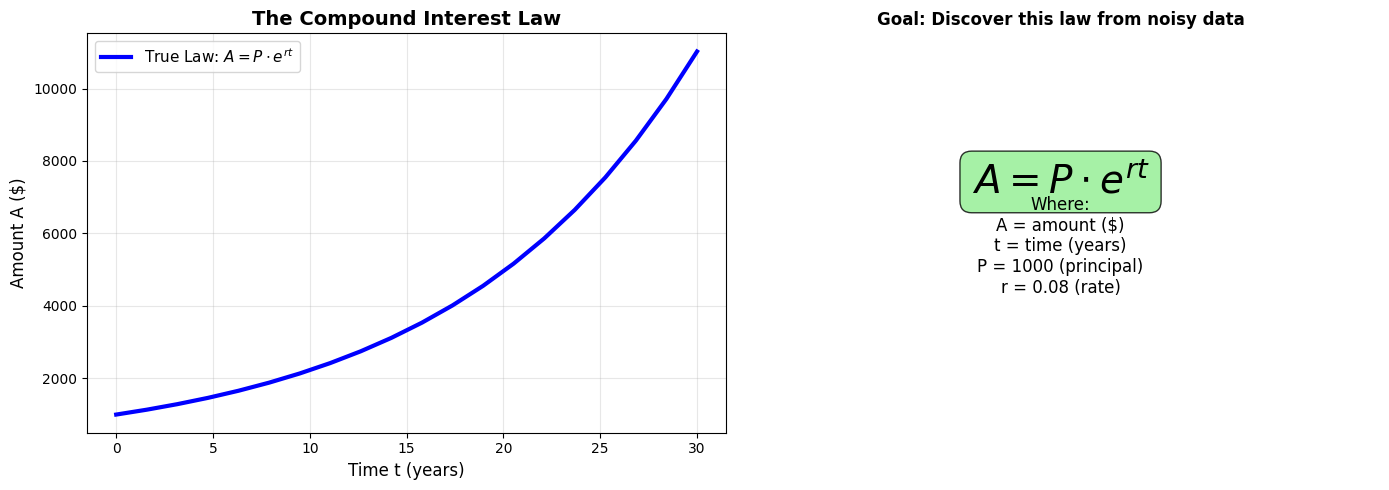

In [3]:
print("\n" + "=" * 80)
print("AUTONOMOUS SCIENTIFIC DISCOVERY DEMONSTRATION")
print("Discovering the Compound Interest Law from Noisy Data")
print("=" * 80)

# Generate data
t, A_noisy, A_true = generate_compound_interest_data(
    principal=CONFIG['principal'],
    rate=CONFIG['rate'],
    noise_level=CONFIG['noise_level'],
    num_points=20
)

# Show introduction
plot_introduction(t, A_true, CONFIG['principal'], CONFIG['rate'])

### Step 2: Show the Noisy Data

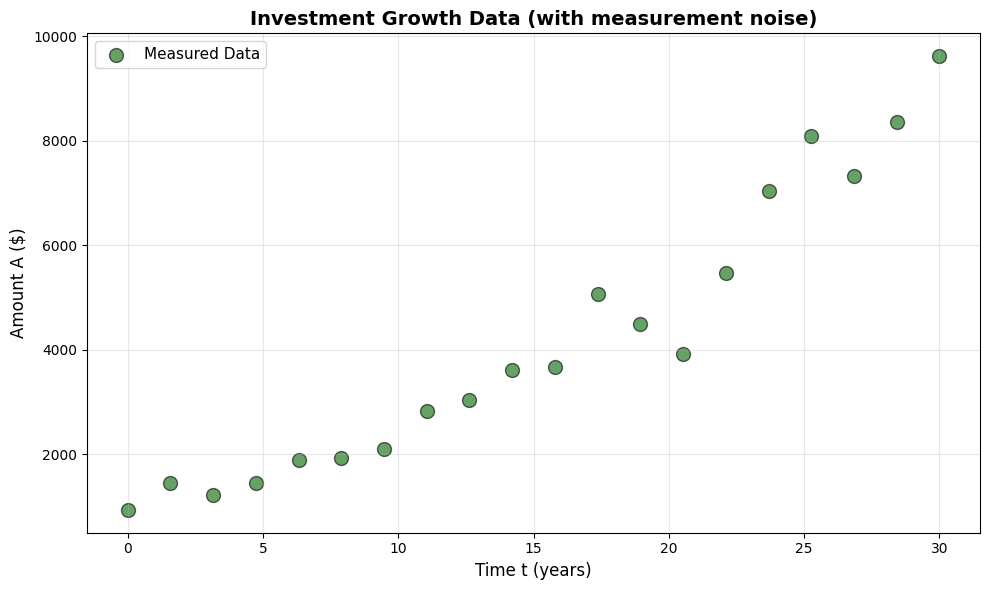

This is all the AI will see! Can it discover the underlying exponential law?


In [4]:
plot_noisy_data(t, A_noisy)
print("This is all the AI will see! Can it discover the underlying exponential law?")

### Step 3: Run Autonomous Discovery

**This will call the LLM API!** Make sure you've set your API key in the CONFIG above.

In [9]:
# Run the discovery process
iterations = run_autonomous_discovery(t, A_noisy, CONFIG)

STARTING AUTONOMOUS SCIENTIFIC DISCOVERY
Provider: openai
Model: gpt-5
Max Iterations: 3


ITERATION 1

üìù PROMPT SENT TO LLM:
--------------------------------------------------------------------------------
You are a scientific AI agent discovering mathematical laws from experimental data.

EXPERIMENTAL DATA:
t=0.0, A=935.49
t=1.6, A=1454.57
t=3.2, A=1232.44
t=4.7, A=1456.29
t=6.3, A=1895.46
t=7.9, A=1929.04
t=9.5, A=2102.43
t=11.1, A=2821.90
t=12.6, A=3036.52
t=14.2, A=3616.98
t=15.8, A=3665.93
t=17.4, A=5063.62
t=18.9, A=4486.86
t=20.5, A=3926.77
t=22.1, A=5470.78
t=23.7, A=7035.76
t=25.3, A=8092.23
t=26.8, A=7325.80
t=28.4, A=8358.01
t=30.0, A=9620.68

IMPORTANT: Discover the relationship purely from the data patterns.
Think step-by-step: examine how A changes as t changes, look for linear, polynomial, exponential, or other relationships.

Your task for iteration 1:
1. Analyze the relationship between t and A in the data
2. Propose a mathematical equation: A = [function of t]
3. 

### Step 4: Display Final Summary

In [6]:
if iterations:
    display_summary(iterations, t, A_noisy, A_true, CONFIG['principal'], CONFIG['rate'])
else:
    print("\n‚ùå No successful iterations completed.")

print("\n‚úÖ Demo complete!")


‚ùå No successful iterations completed.

‚úÖ Demo complete!


## 12. Optional: Inspect Individual Iterations

You can examine the details of any specific iteration:

In [7]:
# Example: Look at iteration 1 in detail
if iterations:
    iteration_num = 1  # Change this to see different iterations
    
    if iteration_num <= len(iterations):
        iter_data = iterations[iteration_num - 1]
        
        print(f"\n{'='*80}")
        print(f"DETAILED VIEW: ITERATION {iteration_num}")
        print(f"{'='*80}\n")
        
        print("REASONING:")
        print("-" * 80)
        print(iter_data['reasoning'])
        print("-" * 80)
        print()
        
        print(f"EQUATION: {iter_data['equation']}")
        print(f"CONFIDENCE: {iter_data['confidence']}")
        print(f"R¬≤ SCORE: {iter_data['r_squared']:.4f}")
    else:
        print(f"Iteration {iteration_num} not found. Only {len(iterations)} iterations completed.")

## 13. Presentation Tips & Talking Points

### üé§ For Your Presentation

**Setup (Before Demo):**
1. **Run cells 1-10 sequentially** to load all functions
2. **Set your API key** in cell 2 (CONFIG section)
3. **Adjust `max_iterations`** to 3-4 for live demos (faster)
4. Consider lowering `noise_level` to 0.10 for more consistent results

---

### üí° Key Talking Points

**Opening Hook:**
> "Compound interest - Einstein supposedly called it the eighth wonder of the world. Today, we're going to see if AI can rediscover the exponential growth law from raw data, without being told what it's looking at."

**During the Discovery Process:**
- **Iteration 1**: "Notice the AI is exploring different relationships - linear, polynomial, exponential..."
- **Mid-iterations**: "The AI learns from its mistakes - each R¬≤ score shows how well the hypothesis fits"
- **Final iteration**: "The AI has converged on an exponential relationship - the same law that governs investment growth!"

**Key Insights to Highlight:**
1. **Autonomous Reasoning**: The AI proposes hypotheses, tests them, and iterates - mimicking scientific discovery
2. **Pattern Recognition**: Despite 15% noise, the AI identifies the underlying exponential relationship
3. **No Domain Knowledge**: The system wasn't told this was compound interest or given any financial formulas
4. **Universal Applicability**: This same exponential law appears in population growth, radioactive decay, and viral spread

---

### üéØ Discussion Questions for Audience

- "What other phenomena follow exponential growth or decay?"
- "How could this approach be used in finance, economics, or epidemiology?"
- "What are the limitations? When might the AI fail to discover the law?"
- "Could this help identify new growth patterns in business or scientific data?"

---

### ‚öôÔ∏è Troubleshooting Tips

**If the AI struggles:**
- Reduce noise level to 0.10
- Increase max_iterations to 5-7
- Set `enable_hints: True` in CONFIG

**If API calls are slow:**
- Use a faster model (e.g., `claude-3-5-haiku`)
- Or switch to local Ollama for offline demos

**For dramatic effect:**
- Use `noise_level: 0.20` to show robustness
- Show comparison with true law at the end
- Highlight the exponential curve's dramatic growth at later time points